<a href="https://colab.research.google.com/github/abhishek-parashar/corona-virus-analysis/blob/master/corona_virus_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Declaration

### For past few weeks, I have gone through a lot of literature, blogs, codes, videos and what not. 
### The information here is right to my knowledge, this is just a simple analysis and my views for the topic, as a machine learning programmer. 
### Please don't take this blog or code as the sole work on the topic.
### For more information please refer the Government of India site, Research papers, Youtube videos, Github etc. 
### Information provided at the Government of India site https://www.mohfw.gov.in/ is correct and to be referred for the analysis 

I have shared all the links to the dataset, resources for learning about COVID-19, time-series analysis and various lectures on visualization and real-time analysis on my blog post. 
Kindly refer that for further information.
These are the resources where I learned this analysis. 

In [0]:

import json
from datetime import timedelta
from urllib.request import urlopen
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
cnf = '#393e46' # confirmed - grey
dth = '#ff2e63' # death - red
rec = '#21bf73' # recovered - cyan
act = '#fe9801' # active case - yellow
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [41]:
!pip install geopandas

In [0]:
import geopandas as gpd

In [0]:
import keras 

In [0]:
import tensorflow as tf

In [45]:
tf.__version__

'2.2.0-rc2'

In [0]:
! ls ../input/covid19-corona-virus-india-dataset

ls: cannot access '../input/covid19-corona-virus-india-dataset': No such file or directory


In [46]:
from zipfile import ZipFile
file_name= "covid19-corona-virus-india-dataset.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [0]:
df = pd.read_csv('complete.csv', parse_dates=['Date'])

In [0]:
df['Name of State / UT'] = df['Name of State / UT'].str.replace('Union Territory of ', '')

In [49]:
df.head()

,Date,Name of State / UT,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Latitude,Longitude,Death,Total Confirmed cases
0,2020-01-30,Kerala,1,0,0,10.8505,76.2711,0,1
1,2020-01-31,Kerala,1,0,0,10.8505,76.2711,0,1
2,2020-02-01,Kerala,2,0,0,10.8505,76.2711,0,2
3,2020-02-02,Kerala,3,0,0,10.8505,76.2711,0,3
4,2020-02-03,Kerala,3,0,0,10.8505,76.2711,0,3


In [50]:
df.columns

Index(['Date', 'Name of State / UT', 'Total Confirmed cases (Indian National)',
       'Total Confirmed cases ( Foreign National )',
       'Cured/Discharged/Migrated', 'Latitude', 'Longitude', 'Death',
       'Total Confirmed cases'],
      dtype='object')

In [0]:
# calculating mortality rate. recovery rate and active cases by the reported cases, death, cured discharged.
df = df[['Date', 'Name of State / UT', 'Latitude', 'Longitude', 'Total Confirmed cases', 'Death', 'Cured/Discharged/Migrated']]
df.columns = ['Date', 'State/UT', 'Latitude', 'Longitude', 'Confirmed', 'Deaths', 'Cured']

In [0]:
for i in ['Confirmed', 'Deaths', 'Cured']:
    df[i] = df[i].astype('int')
    
df['Active'] = df['Confirmed'] - df['Deaths'] - df['Cured']
df['Mortality rate'] = df['Deaths']/df['Confirmed']
df['Recovery rate'] = df['Cured']/df['Confirmed']

In [0]:
df = df[['Date', 'State/UT', 'Latitude', 'Longitude', 'Confirmed', 'Active', 'Deaths', 'Mortality rate', 'Cured', 'Recovery rate']]

In [54]:
df.head()

,Date,State/UT,Latitude,Longitude,Confirmed,Active,Deaths,Mortality rate,Cured,Recovery rate
0,2020-01-30,Kerala,10.8505,76.2711,1,1,0,0.0,0,0.0
1,2020-01-31,Kerala,10.8505,76.2711,1,1,0,0.0,0,0.0
2,2020-02-01,Kerala,10.8505,76.2711,2,2,0,0.0,0,0.0
3,2020-02-02,Kerala,10.8505,76.2711,3,3,0,0.0,0,0.0
4,2020-02-03,Kerala,10.8505,76.2711,3,3,0,0.0,0,0.0


In [0]:
# latest cases 
latest = df[df['Date']==max(df['Date'])]

In [0]:
# days
latest_day = max(df['Date'])
day_before = latest_day - timedelta(days = 1)

In [0]:
# state and total cases 
latest_day_df = df[df['Date']==latest_day].set_index('State/UT')
day_before_df = df[df['Date']==day_before].set_index('State/UT')

In [0]:
temp = pd.merge(left = latest_day_df, right = day_before_df, on='State/UT', suffixes=('_lat', '_bfr'), how='outer')
latest_day_df['New cases'] = temp['Confirmed_lat'] - temp['Confirmed_bfr']
latest = latest_day_df.reset_index()
latest.fillna(1, inplace=True)

In [59]:
print(latest_day, day_before)

2020-04-05 00:00:00 2020-04-04 00:00:00


In [0]:
# sorting the latest values in descending order 
temp = latest[['State/UT', 'Confirmed', 'Active', 'New cases', 'Deaths', 'Mortality rate', 'Cured', 'Recovery rate']]
temp = temp.sort_values('Confirmed', ascending=False).reset_index(drop=True)

In [61]:
# ploting the latest values 
temp.style\
    .background_gradient(cmap="Blues", subset=['Confirmed', 'Active', 'New cases'])\
    .background_gradient(cmap="Greens", subset=['Cured', 'Recovery rate'])\
    .background_gradient(cmap="Reds", subset=['Deaths', 'Mortality rate'])

,State/UT,Confirmed,Active,New cases,Deaths,Mortality rate,Cured,Recovery rate
0,Maharashtra,490,424,67.000000,24,0.048980,42,0.085714
1,Tamil Nadu,485,476,74.000000,3,0.006186,6,0.012371
2,Delhi,445,424,59.000000,6,0.013483,15,0.033708
3,Kerala,306,255,11.000000,2,0.006536,49,0.160131
4,Telengana,269,230,111.000000,7,0.026022,32,0.118959
5,Uttar Pradesh,227,206,53.000000,2,0.008811,19,0.083700
6,Rajasthan,200,179,21.000000,0,0.000000,21,0.105000
7,Andhra Pradesh,161,159,0.000000,1,0.006211,1,0.006211
8,Karnataka,144,128,16.000000,4,0.027778,12,0.083333
9,Gujarat,105,81,10.000000,10,0.095238,14,0.133333


## plotting the Map because it's cool
![alt text](https://drive.google.com/uc?id=1OG6iz85GiIZipkCrEdQrn5ortwt3LVq4)

In [62]:
# map plot
m = folium.Map(location=[20.5937, 78.9629], tiles='cartodbpositron',
               min_zoom=4, max_zoom=6, zoom_start=4)

for i in range(0, len(latest)):
    if latest.iloc[i]['Confirmed']>0:
        folium.Circle(
            location=[latest.iloc[i]['Latitude'], latest.iloc[i]['Longitude']],
            color='#e84545', 
            fill='#e84545',
            tooltip =   '<li><bold>Name of State / UT : '+str(latest.iloc[i]['State/UT'])+
                        '<li><bold>Confirmed cases  : '+str(latest.iloc[i]['Confirmed']),
            radius=int(latest.iloc[i]['Confirmed'])*300).add_to(m)
m            

In [63]:
# plotting the confirmed cases state wise
conf = latest.sort_values('Confirmed', ascending=False)
state_order = conf['State/UT']

fig = px.bar(conf, 
             x="Confirmed", y="State/UT", color='State/UT', title='Confirmed',
             orientation='h', text='Confirmed', height=len(conf)*35,
             color_discrete_sequence = px.colors.qualitative.Vivid)
fig.show()

In [64]:
# deaths and recovered cases
temp = latest[latest['Deaths']>0].sort_values('Deaths')
fig_d = px.bar(temp, y="State/UT", x="Deaths", orientation='h', title='Deaths', color_discrete_sequence = ['#ff2e63'], text='Deaths', height=len(temp)*40)

temp = latest[latest['Cured']>0].sort_values('Cured')
fig_r = px.bar(temp, y="State/UT", x="Cured", orientation='h', title='Cured', color_discrete_sequence = ['#2c786c'], text='Cured', height=len(temp)*40)

fig = make_subplots(rows=1, cols=2, shared_xaxes=False, horizontal_spacing=0.2, subplot_titles=("Deaths", "Recovered"))
fig.add_trace(fig_d['data'][0], row=1, col=1)
fig.add_trace(fig_r['data'][0], row=1, col=2)
fig.update_layout(height=800)
fig.show()

## Here we complete all the visualisation now it's time for forecasting!!!
![alt text](https://drive.google.com/uc?id=1Zpl-L9qUpxNBeh9ffNr_DsYh7lGys8Hf)

In [65]:
df.head()

,Date,State/UT,Latitude,Longitude,Confirmed,Active,Deaths,Mortality rate,Cured,Recovery rate
0,2020-01-30,Kerala,10.8505,76.2711,1,1,0,0.0,0,0.0
1,2020-01-31,Kerala,10.8505,76.2711,1,1,0,0.0,0,0.0
2,2020-02-01,Kerala,10.8505,76.2711,2,2,0,0.0,0,0.0
3,2020-02-02,Kerala,10.8505,76.2711,3,3,0,0.0,0,0.0
4,2020-02-03,Kerala,10.8505,76.2711,3,3,0,0.0,0,0.0


In [0]:
df=df['Confirmed']

In [67]:
df.head(10)

0    1
1    1
2    2
3    3
4    3
5    3
6    3
7    3
8    3
9    3
Name: Confirmed, dtype: int64

In [0]:
df.to_csv('time_series')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

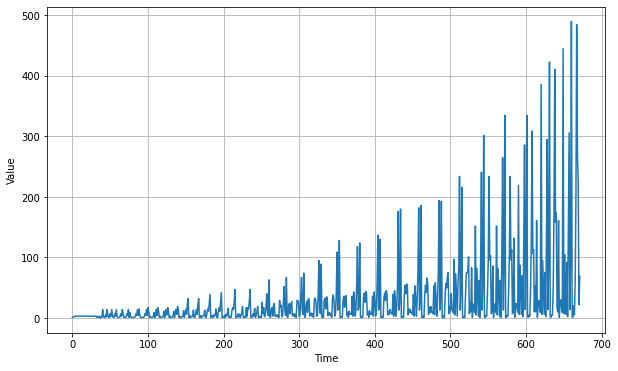

In [70]:
import csv
time_step = []
temps = []

with open('time_series') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 50
shuffle_buffer_size = 100

In [75]:
x_train.shape

(500,)

In [76]:
x_valid.shape

(172,)

In [0]:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(150).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [86]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 30
batch_size = 50
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  # tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(16, return_sequences=True),
  # tf.keras.layers.LSTM(64, return_sequences=True),
  
  # tf.keras.layers.Dense(64, activation="relu"),
  # tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),

  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(500,)
Epoch 1/100
10/10 [==============================] - 0s 15ms/step - loss: 26.3030 - mae: 26.3396 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 26.2759 - mae: 26.3193 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 0s 16ms/step - loss: 26.0974 - mae: 26.2897 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 0s 15ms/step - loss: 26.0512 - mae: 26.2532 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 0s 15ms/step - loss: 26.1790 - mae: 26.2116 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 26.0541 - mae: 26.1653 - lr: 1.7783e-08
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 26.2781 - mae: 26.1133 - lr: 1.9953e-08
Epoch 8/100
10/10 [==============================] - 0s 14ms/step - loss: 26.2338 - mae: 26.0541 - lr

(1e-08, 0.001, 0.0, 60.0)

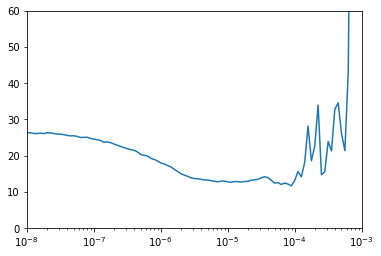

In [87]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 60])

In [101]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=50, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  # tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(16, return_sequences=True),
  # tf.keras.layers.LSTM(8, return_sequences=True),
  
  # tf.keras.layers.Dense(64, activation="relu"),
  # tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),

  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
10/10 [==============================] - 0s 14ms/step - loss: 24.6932 - mae: 24.8833
Epoch 2/150
10/10 [==============================] - 0s 12ms/step - loss: 18.8797 - mae: 18.9859
Epoch 3/150
10/10 [==============================] - 0s 15ms/step - loss: 14.8751 - mae: 14.9915
Epoch 4/150
10/10 [==============================] - 0s 15ms/step - loss: 14.2055 - mae: 14.3191
Epoch 5/150
10/10 [==============================] - 0s 12ms/step - loss: 13.3396 - mae: 13.3374
Epoch 6/150
10/10 [==============================] - 0s 12ms/step - loss: 13.0872 - mae: 13.0704
Epoch 7/150
10/10 [==============================] - 0s 14ms/step - loss: 13.2430 - mae: 13.0306
Epoch 8/150
10/10 [==============================] - 0s 15ms/step - loss: 13.1114 - mae: 12.8970
Epoch 9/150
10/10 [==============================] - 0s 15ms/step - loss: 12.8130 - mae: 12.7541
Epoch 10/150
10/10 [==============================] - 0s 12ms/step - loss: 12.6766 - mae: 12.6504
Epoch 11/150
10/10 [=========

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

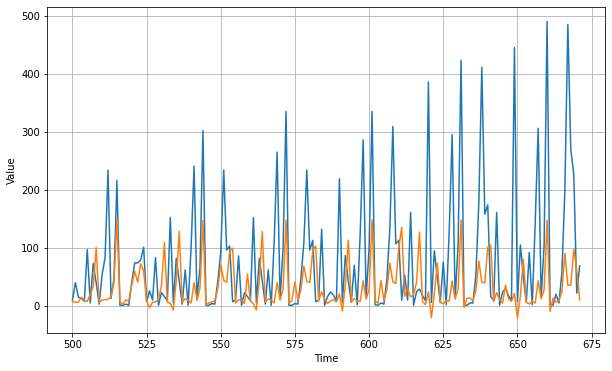

In [106]:
# the exceptional spikes are outliers they are to be ignored the model learns well
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [104]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

62.823742

In [105]:
print(rnn_forecast)

[  7.740863    6.0141115   6.521071   14.632479    9.6843605   7.463829
  19.845713   33.327698  100.78242     5.813787    9.699145   10.75957
  11.262088   16.187077   40.293465  148.81366     6.6925874   3.3449595
  10.119345    8.838594   36.40574    59.4391     40.924366   72.3793
  60.645657    9.000965   -3.284047    6.0594645   6.788377   10.392273
  34.503284  108.95905     6.351136    4.448691   -7.083919   42.8723
 128.40659     6.132408   12.376601    9.573764    4.995588   39.900364
   9.274725   30.371136  147.12167     1.7245419   5.0585856   6.6676774
   8.823508   29.749144   70.52052    43.80459    40.804462   94.444824
  99.201126    4.913641   10.199365   10.00701     4.038583   54.971268
   8.369482    3.7196047  -6.759324   44.346912  127.9357      6.1562634
  12.35615     9.587664    5.0356474  40.57013    10.110433   28.521246
 147.6456      4.3982177   9.444217   41.577454    8.838395   28.037851
  68.431274   42.349045   40.121605   94.7269    103.08429     8.2